<a id='s0'></a>
## <font color='darkblue'>Preface</font>
<b><font size='3ptx'>This notebook is a copy from [this course](https://developers.google.com/machine-learning/clustering/workflow) and the original colab is [here](https://colab.sandbox.google.com/github/google/eng-edu/blob/main/ml/clustering/clustering-manual-similarity.ipynb?utm_source=ss-clustering&utm_campaign=colab-external&utm_medium=referral&utm_content=clustering-manual-similarity).</font></b>

In this Colab, you will group chocolates in the
[Chocolate Bar Ratings](https://www.kaggle.com/rtatman/chocolate-bar-ratings)
dataset using the k-means clustering algorithm with a manual similarity measure. The dataset has ratings
of chocolate bars along with their cocoa percentage, bean type, bean origin,
maker name, and maker country. You will:

*   [Load and clean the data.](#s1)
*   [Process the data.](#s2)
*   [Calculate similarity between pairs of chocolates.](#s3)
*   [Cluster the chocolates using k-means.](#s4)
*   [Check the clustering result using quality metrics.](#s5)

In [1]:
import math

from matplotlib import pyplot as plt
from numpy.polynomial.polynomial import polyfit
import numpy as np
import numpy.linalg as nla
import pandas as pd
import seaborn as sns
import altair as alt
import re
import pdb  # for Python debugger
import sys
from os.path import join

# Set the output display to have one digit for decimal places and limit it to
# printing 15 rows.
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

In [2]:
def cleanup_spelling_abbrev(text):
    replacements = [
        ['-', ', '], ['/ ', ', '], ['/', ', '], ['\(', ', '], [' and', ', '], [' &', ', '], ['\)', ''],
        ['Dom Rep|DR|Domin Rep|Dominican Rep,|Domincan Republic', 'Dominican Republic'],
        ['Mad,|Mad$', 'Madagascar, '],
        ['PNG', 'Papua New Guinea, '],
        ['Guat,|Guat$', 'Guatemala, '],
        ['Ven,|Ven$|Venez,|Venez$', 'Venezuela, '],
        ['Ecu,|Ecu$|Ecuad,|Ecuad$', 'Ecuador, '],
        ['Nic,|Nic$', 'Nicaragua, '],
        ['Cost Rica', 'Costa Rica'],
        ['Mex,|Mex$', 'Mexico, '],
        ['Jam,|Jam$', 'Jamaica, '],
        ['Haw,|Haw$', 'Hawaii, '],
        ['Gre,|Gre$', 'Grenada, '],
        ['Tri,|Tri$', 'Trinidad, '],
        ['C Am', 'Central America'],
        ['S America', 'South America'],
        [', $', ''], [',  ', ', '], [', ,', ', '], ['\xa0', ' '],[',\s+', ','],
        [' Bali', ',Bali']
    ]
    for i, j in replacements:
        text = re.sub(i, j, text)
    return text

<a id='s1'></a>
## <font color='darkblue'>1. Load and clean data</font> ([back](#s0))
Run the following cell to load and clean the chocolate dataset. You do not need to
understand the code. The first few rows of the dataset are displayed. Inspect
the features and their values.

In [3]:
%%time
data_src_url = "https://download.mlcc.google.com/mledu-datasets/flavors_of_cacao.csv"
choc_data = pd.read_csv(data_src_url, sep=",", encoding='latin-1')

CPU times: user 94.7 ms, sys: 9.53 ms, total: 104 ms
Wall time: 148 ms


In [4]:
# We can rename the columns.
choc_data.columns = [
    'maker', 'specific_origin', 'reference_number', 'review_date', 'cocoa_percent',
    'maker_location', 'rating', 'bean_type', 'broad_origin']

In [5]:
# Replace empty/null values with "Blend"
choc_data['bean_type'] = choc_data['bean_type'].fillna('Blend')

In [6]:
#@title Cast bean_type to string to remove leading 'u'
choc_data['bean_type'] = choc_data['bean_type'].astype(str)
choc_data['cocoa_percent'] = choc_data['cocoa_percent'].str.strip('%')
choc_data['cocoa_percent'] = pd.to_numeric(choc_data['cocoa_percent'])

In [7]:
#@title Correct spelling mistakes, and replace city with country name
choc_data['maker_location'] = choc_data['maker_location']\
    .str.replace('Amsterdam', 'Holland')\
    .str.replace('U.K.', 'England')\
    .str.replace('Niacragua', 'Nicaragua')\
    .str.replace('Domincan Republic', 'Dominican Republic')

/tmp/ipykernel_222703/2510509398.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace('U.K.', 'England')\


In [8]:
# Adding this so that Holland and Netherlands map to the same country.
choc_data['maker_location'] = choc_data['maker_location']\
.str.replace('Holland', 'Netherlands')

In [9]:
choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

#@title Cast specific_origin to string
choc_data['specific_origin'] = choc_data['specific_origin'].astype(str)

#@title Replace null-valued fields with the same value as for specific_origin
choc_data['broad_origin'] = choc_data['broad_origin'].fillna(choc_data['specific_origin'])

#@title Clean up spelling mistakes and deal with abbreviations
choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)

# Change 'Trinitario, Criollo' to "Criollo, Trinitario"
# Check with choc_data['bean_type'].unique()
choc_data.loc[choc_data['bean_type'].isin(['Trinitario, Criollo']),'bean_type'] = "Criollo, Trinitario"
# Confirm with choc_data[choc_data['bean_type'].isin(['Trinitario, Criollo'])]

# Fix chocolate maker names
choc_data.loc[choc_data['maker']=='Shattel','maker'] = 'Shattell'
choc_data['maker'] = choc_data['maker'].str.replace(u'Na\xef\xbf\xbdve','Naive')

# Save the original column names
original_cols = choc_data.columns.values

choc_data.head()

/tmp/ipykernel_222703/3410515206.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  choc_data['specific_origin'] = choc_data['specific_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)
/tmp/ipykernel_222703/3410515206.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  choc_data['broad_origin'] = choc_data['broad_origin'].str.replace('.', '').apply(cleanup_spelling_abbrev)


,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
0,A. Morin,Agua Grande,1876,2016,63.00,France,3.75,Blend,Sao Tome
1,A. Morin,Kpime,1676,2015,70.00,France,2.75,Blend,Togo
2,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
3,A. Morin,Akata,1680,2015,70.00,France,3.50,Blend,Togo
4,A. Morin,Quilla,1704,2015,70.00,France,3.50,Blend,Peru


<a id='s2'></a>
## <font color='darkblue'>2. Preprocess Data</font> ([back](#s0))
You will preprocess your data using the techniques described in
[Prepare Data](https://developers.google.com/machine-learning/clustering/prepare-data).

Let's start with the feature `review_date`. If you assume that chocolate making
did not change over the 10 years of data, then `review_date` has no correlation
with the chocolate itself. You can safely ignore the feature. However, as a good data scientist, you should be curious about your data. Let's
plot the distribution for `review date` using a function from the Seaborn data visualization library. It looks like no one ate chocolate in 2009 and 2013. However, the
overall chocolate eating trend is positive and very encouraging. This is a good
time to eat some chocolate yourself!

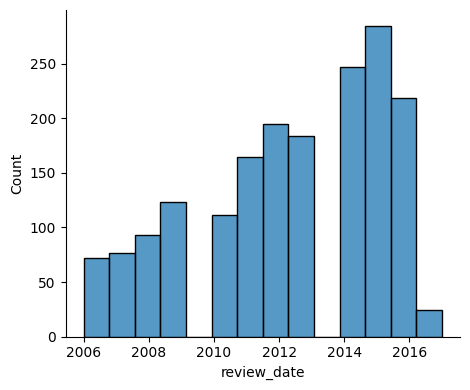

In [10]:
# sns.set(rc={'figure.figsize':(5, 6)})
sns.displot(choc_data['review_date'],
            height=4, aspect=1.2)

Plot the distribution for `rating`. Consider how you'd process this distribution. Then move ahead for the answer.

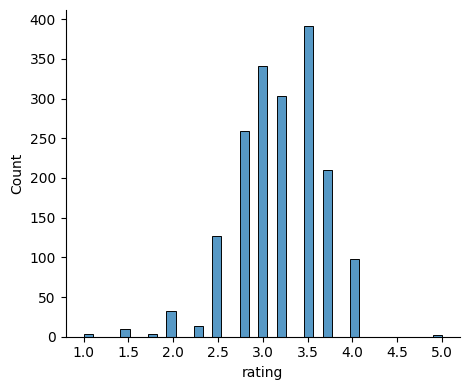

In [11]:
# check the distribution
sns.displot(choc_data['rating'], height=4, aspect=1.2)

The distribution for `rating` is roughly a Gaussian distribution. How are Gaussian distributions processed? You know it. Normalize the data.

In [12]:
# its a Gaussian! So, use z-score to normalize the data
choc_data['rating_norm'] = (
    choc_data['rating'] - choc_data['rating'].mean()) / choc_data['rating'].std()

Examine the distribution for `cocoa_percent` and consider how to process it. Then check below for the answer.

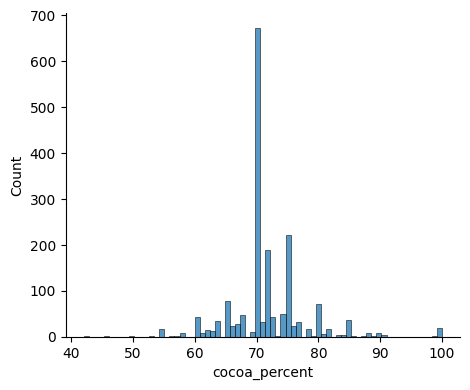

In [13]:
sns.displot(choc_data['cocoa_percent'], height=4, aspect=1.2)

The distribution for `cocoa_percent` is close enough to a Gaussian distribution. Normalize the data.

In [14]:
choc_data['cocoa_percent_norm'] = (
    choc_data['cocoa_percent'] -
    choc_data['cocoa_percent'].mean()) / choc_data['cocoa_percent'].std()

Display the first few rows to check the normalization for `rating` and `cocoa_percent`.

In [15]:
choc_data[['rating_norm', 'cocoa_percent_norm']].head()

,rating_norm,cocoa_percent_norm
0,1.18,-1.38
1,-0.91,-0.27
2,-0.39,-0.27
3,0.66,-0.27
4,0.66,-0.27


You have the cocoa beans' country of origin in `broad_origin` and the chocolates' country of manufacture in `maker_location`. However, to calculate similarity, you need the longitude and latitude
of the countries. Luckily, this geographic information is available in another table on
developers.google.com! The following code downloads the Dataset Publishing Language (DSPL)
Countries table and joins it with our chocolate reviews table, using the country
name as the key. Note that you are approximating countries by the latitude and longitude of their centers.

Display the first few rows to spot
check the processed data. Notice the newly created `maker_lat`, `maker_long`, `origin_lat`, and `origin_long` fields. Do the values in fields match your expectations? 

In [16]:
# Load lat long data
countries_info_url = "https://download.mlcc.google.com/mledu-datasets/countries_lat_long.csv"
countries_info = pd.read_csv(countries_info_url, sep=",", encoding='latin-1')

In [17]:
countries_info.head()

,country,latitude,longitude,name
0,AD,42.55,1.60,Andorra
1,AE,23.42,53.85,United Arab Emirates
2,AF,33.94,67.71,Afghanistan
3,AG,17.06,-61.80,Antigua and Barbuda
4,AI,18.22,-63.07,Anguilla


In [18]:
#Join the chocolate review and geographic information tables on maker country name
choc_data = pd.merge(
    choc_data, countries_info, left_on="maker_location", right_on="name")
choc_data.rename(
    columns={
        "longitude": "maker_long",
        "latitude": "maker_lat"
    }, inplace=True)

In [19]:
choc_data.drop(
    columns=["name", "country"], inplace=True)  # don't need this data

In [20]:
#Join the chocolate review and geographic information tables on origin country name
choc_data = pd.merge(
    choc_data, countries_info, left_on="broad_origin", right_on="name")
choc_data.rename(
    columns={
        "longitude": "origin_long",
        "latitude": "origin_lat"
    },
    inplace=True)
choc_data.drop(
    columns=["name", "country"], inplace=True)  # don't need this data

In [21]:
choc_data[['maker_long', 'maker_lat', 'origin_long', 'origin_lat']].head()

,maker_long,maker_lat,origin_long,origin_lat
0,2.21,46.23,0.82,8.62
1,2.21,46.23,0.82,8.62
2,2.21,46.23,0.82,8.62
3,2.21,46.23,-75.02,-9.19
4,2.21,46.23,-75.02,-9.19


Check the distribution for the latitudes and longitudes and consider how to process the distributions. Then check below for the answer.

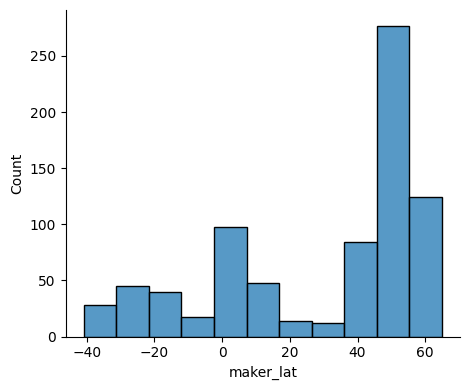

In [22]:
sns.displot(choc_data['maker_lat'], height=4, aspect=1.2)

Since latitude and longitude don't follow a specific distribution, convert the
latitude and longitude information into quantiles. Display the last few rows to verify the quantile values.

In [23]:
num_quantiles = 20
cols_quantiles = ['maker_lat', 'maker_long', 'origin_lat', 'origin_long']

def create_quantiles(df_column, num_quantiles):
    return pd.qcut(df_column, num_quantiles, labels=False, duplicates='drop')


for col_name in cols_quantiles:
    choc_data[col_name] = create_quantiles(choc_data[col_name], num_quantiles)
  

choc_data[cols_quantiles].tail()

,maker_lat,maker_long,origin_lat,origin_long
782,6,0,10,1
783,6,13,10,12
784,6,0,10,0
785,6,0,10,0
786,4,4,7,8


Quantile values range up to 20. Bring quantile values to the same scale as other feature data by scaling them to `[0,1]`.

In [24]:
def min_max_scaler(num_arr):
    min_v = np.min(num_arr)
    max_v = np.max(num_arr)
    num_arr = (num_arr - min_v) / (max_v - min_v)
    return num_arr


for col_name in cols_quantiles:
    choc_data[col_name] = min_max_scaler(choc_data[col_name])

The features `maker` and `bean_type` are categorical features. Convert
categorical features into one-hot encoding.

In [25]:
# duplicate the "maker" feature since it's removed by one-hot encoding function
choc_data['maker2'] = choc_data['maker']
choc_data = pd.get_dummies(choc_data, columns=['maker2'], prefix=['maker'])

# similarly, duplicate the "bean_type" feature
choc_data['bean_type2'] = choc_data['bean_type']
choc_data = pd.get_dummies(choc_data, columns=['bean_type2'], prefix=['bean'])

After clustering, when you interpret the results, the processed feature data is
hard to read. Save the original feature data in a new dataframe so you can
reference it later. Keep only the processed data in `choc_data`.

In [26]:
# Split dataframe into two frames: Original data and data for clustering
choc_data_backup = choc_data.loc[:, original_cols].copy(deep=True)
choc_data.drop(columns=original_cols, inplace=True)

# get_dummies returned ints for one-hot encoding but we want floats so divide by
# 1.0
# Note: In the latest version of "get_dummies", you can set "dtype" to float
choc_data = choc_data / 1.0

Inspect the last few records to ensure your precious chocolate data is looking
good! Remember that `choc_data` only shows columns with processed data because the columns holding the original data were moved to `choc_data_backup`.

In [27]:
choc_data.tail()

,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),...,bean_Forastero (Arriba) ASSS,bean_Forastero (Catongo),bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA"
782,0.66,-0.27,0.40,0.00,0.77,0.08,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
783,0.66,-1.06,0.40,0.87,0.77,0.92,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
784,-0.91,1.31,0.40,0.00,0.77,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
785,-0.39,-0.27,0.40,0.00,0.77,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
786,0.13,-0.27,0.27,0.27,0.54,0.62,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


<a id='s3'></a>
## <font color='darkblue'>3. Calculate Manual Similarity</font> ([back](#s0))
You've worked hard to process the data! Now calculating similarity between a
pair of chocolates is simple because all the features are numeric and in the
same range. For any two chocolates, simply find the root mean square error
(RMSE) of all features.

First run this code to define the similarity function.

In [28]:
def get_similarity(obj1, obj2):
    len1 = len(obj1.index)
    len2 = len(obj2.index)
    if not (len1 == len2):
        print("Error: Compared objects must have same number of features.")
        return 0
    else:
        similarity = obj1 - obj2
        similarity = np.sum((similarity**2.0) / 10.0)
        similarity = 1 - math.sqrt(similarity)
        return similarity

Now calculate the similarity between the first chocolate and the next 4
chocolates. Verify the calculated similarity against your intuitive expectations
by comparing the calculated similarity to the actual feature data shown in the
next cell.

If you're curious about similarities between other chocolates, do modify the
code below and take a look!

In [29]:
choc1 = 0  #@param
chocsToCompare = [1, 4]  #@param

print("Similarity between chocolates " + str(choc1) + " and ...")

for ii in range(chocsToCompare[0], chocsToCompare[1] + 1):
    print(str(ii) + ": " + str(
        get_similarity(choc_data.loc[choc1], choc_data.loc[ii])))

print("\n\nFeature data for chocolate " + str(choc1))
print(choc_data_backup.loc[choc1:choc1, :])
print("\n\nFeature data for compared chocolates " + str(chocsToCompare))
print(choc_data_backup.loc[chocsToCompare[0]:chocsToCompare[1], :])

Similarity between chocolates 0 and ...
1: 0.8346304947537501
2: 0.5038914842612502
3: 0.4555557720237352
4: 0.14327793910574316


Feature data for chocolate 0
      maker specific_origin  reference_number  review_date  cocoa_percent  \
0  A. Morin           Kpime              1676         2015          70.00   

  maker_location  rating bean_type broad_origin  
0         France    2.75     Blend         Togo  


Feature data for compared chocolates [1, 4]
      maker specific_origin  reference_number  review_date  cocoa_percent  \
1  A. Morin          Atsane              1676         2015          70.00   
2  A. Morin           Akata              1680         2015          70.00   
3  A. Morin          Quilla              1704         2015          70.00   
4  A. Morin         Pablino              1319         2014          70.00   

  maker_location  rating bean_type broad_origin  
1         France    3.00     Blend         Togo  
2         France    3.50     Blend         Togo  
3  

<a id='s4'></a>
## <font color='darkblue'>4. Cluster Chocolate Dataset</font> ([back](#s0))

We're ready to cluster the chocolates! Run the code to setup the k-means
clustering functions. You do not need to understand the code.

**Note**: If you're following the self study, then before running the rest of
this Colab, read the sections on
[k-means](https://developers.google.com/machine-learning/clustering/algorithm/run-algorithm)
and
[quality metrics](https://developers.google.com/machine-learning/clustering/interpret).

In [30]:
def df_similarity(df, centroids):
    ### df_similarity = Calculate similarities for dataframe input
    ### We need to calculate ||a-b||^2 = |a|^2 + |b|^2 - 2*|a|*|b|
    ### Implement this with matrix operations
    ### See the Appendix for further explanation
    numPoints = len(df.index)
    numCentroids = len(centroids.index)
    ## Strictly speaking, we don't need to calculate the norm of points
    # because it adds a constant bias to distances
    # But calculating it so that the similarity doesn't go negative
    # And that we expect similarities in [0,1] which aids debugging
    pointNorms = np.square(nla.norm(df, axis=1))
    pointNorms = np.reshape(pointNorms, [numPoints, 1])
    ## Calculate the norm of centroids
    centroidNorms = np.square(nla.norm(centroids, axis=1))
    centroidNorms = np.reshape(centroidNorms, (1, numCentroids))
    ## Calculate |a|^2 + |b|^2 - 2*|a|*|b|
    similarities = pointNorms + centroidNorms - 2.0 * np.dot(
        df, np.transpose(centroids))
    # Divide by the number of features
    # Which is 10 because the one-hot encoding means the "Maker" and "Bean" are
    # weighted twice
    similarities = similarities / 10.0
    # numerical artifacts lead to negligible but negative values that go to NaN on the root
    similarities = similarities.clip(min=0.0)
    # Square root since it's ||a-b||^2
    similarities = np.sqrt(similarities)
    return similarities


def init_centroids(df, k, feature_cols):
    # Pick 'k' examples are random to serve as initial centroids
    limit = len(df.index)
    centroids_key = np.random.randint(0, limit - 1, k)
    centroids = df.loc[centroids_key, feature_cols].copy(deep=True)
    # the indexes get copied over so reset them
    centroids.reset_index(drop=True, inplace=True)
    return centroids


def pt2centroid(df, centroids, feature_cols):
    ### Calculate similarities between all points and centroids
    ### And assign points to the closest centroid + save that distance
    numCentroids = len(centroids.index)
    numExamples = len(df.index)
    # df_similarity = Calculate similarities for dataframe input
    dist = df_similarity(df.loc[:, feature_cols], centroids.loc[:, feature_cols])
    df.loc[:, 'centroid'] = np.argmin(dist, axis=1)  # closest centroid
    df.loc[:, 'pt2centroid'] = np.min(dist, axis=1)  # minimum distance
    return df


def recomputeCentroids(df, centroids, feature_cols):
    ### For every centroid, recompute it as an average of the points
    ### assigned to it
    numCentroids = len(centroids.index)
    for cen in range(numCentroids):
        dfSubset = df.loc[df['centroid'] == cen,
                        feature_cols]  # all points for centroid
        if not (dfSubset.empty):  # if there are points assigned to the centroid
            clusterAvg = np.sum(dfSubset) / len(dfSubset.index)
            centroids.loc[cen] = clusterAvg
    return centroids


def kmeans(df, k, feature_cols, verbose):
    flagConvergence = False
    maxIter = 100
    iter = 0  # ensure kmeans doesn't run for ever
    centroids = init_centroids(df, k, feature_cols)
    while not (flagConvergence):
        iter += 1
        #Save old mapping of points to centroids
        oldMapping = df['centroid'].copy(deep=True)
        # Perform k-means
        df = pt2centroid(df, centroids, feature_cols)
        centroids = recomputeCentroids(df, centroids, feature_cols)
        # Check convergence by comparing [oldMapping, newMapping]
        newMapping = df['centroid']
        flagConvergence = all(oldMapping == newMapping)
        if verbose == 1:
            print('Total distance:' + str(np.sum(df['pt2centroid'])))
        if (iter > maxIter):
            print('k-means did not converge! Reached maximum iteration limit of ' \
                    + str(maxIter) + '.')
            sys.exit()
            return
    print('k-means converged for ' + str(k) + ' clusters' + \
            ' after ' + str(iter) + ' iterations!')
    return [df, centroids]

Run the cell to cluster the chocolate dataset, where `k` is the number of clusters.

On every iteration of k-means, the output shows how the sum of distances from all examples to their centroids reduces, such that k-means always converges. The following table shows the data for the first few chocolates. On the extreme right of the table, check the assigned centroid for each example in the centroid column and the distance from the example to its centroid in the pt2centroid column.

In [31]:
k = 30  #@param

feature_cols = choc_data.columns.values  # save original columns
# initialize every point to an impossible value, the k+1 cluster
choc_data['centroid'] = k
# init the point to centroid distance to an impossible value "2" (>1)
choc_data['pt2centroid'] = 2
[choc_data, centroids] = kmeans(choc_data, k, feature_cols, 1)
print("Data for the first few chocolates, with 'centroid' and 'pt2centroid' on"
      ' the extreme right:')

choc_data.head()

Total distance:425.1472522805825
Total distance:339.0567149016557
Total distance:331.21097140661124
Total distance:328.441678295552
Total distance:326.38125423998645
Total distance:325.23758102272524
Total distance:324.3058260435697
Total distance:323.72998192338036
Total distance:323.05031241085624
Total distance:322.4999211626017
Total distance:322.2457210723571
Total distance:322.1733198990629
Total distance:322.1567684534109
Total distance:322.13652160098354
k-means converged for 30 clusters after 14 iterations!
Data for the first few chocolates, with 'centroid' and 'pt2centroid' on the extreme right:


,rating_norm,cocoa_percent_norm,maker_lat,maker_long,origin_lat,origin_long,maker_A. Morin,maker_AMMA,maker_Adi,maker_Aequare (Gianduja),...,bean_Forastero (Nacional),bean_Forastero (Parazinho),bean_Nacional,bean_Nacional (Arriba),bean_Trinitario,bean_Trinitario (85% Criollo),bean_Trinitario (Scavina),"bean_Trinitario, TCGA",centroid,pt2centroid
0,-0.91,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13,0.34
1,-0.39,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7,0.37
2,0.66,-0.27,0.60,0.40,0.62,0.77,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27,0.36
3,0.66,-0.27,0.60,0.40,0.15,0.23,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27,0.34
4,1.70,-0.27,0.60,0.40,0.15,0.23,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27,0.39


### <font color='darkgreen'>4.1 Inspect Clustering Result</font>
Inspect the chocolates in different clusters by changing the parameter `cluster_number`
in the next cell and running the cell. Consider these questions as you inspect the clusters:

*   Are the clusters meaningful?
*   Do the clusters weight certain features more than others? Why?
*   Does changing the number of clusters make the clusters more or less
    meaningful?

After considering these questions, expand the next section for a discussion of clustering results.

In [32]:
cluster_number = 7  #@param
choc_data_backup.loc[choc_data['centroid'] == cluster_number, :]

,maker,specific_origin,reference_number,review_date,cocoa_percent,maker_location,rating,bean_type,broad_origin
1,A. Morin,Atsane,1676,2015,70.00,France,3.00,Blend,Togo
31,Orquidea,Peru,859,2012,65.00,Peru,3.00,Blend,Peru
46,Belcolade,Peru,586,2010,64.00,Belgium,2.75,Blend,Peru
51,Heilemann,Peru,1876,2016,64.00,Germany,2.75,Blend,Peru
52,Kakao,Peru,837,2012,64.00,Germany,2.50,Blend,Peru
...,...,...,...,...,...,...,...,...,...
613,Xocolat,Hispaniola,1057,2013,66.00,Dominican Republic,3.00,Blend,Dominican Republic
632,Svenska Kakaobolaget,Sri Lanka,1618,2015,70.00,Sweden,2.75,"Criollo, Trinitario",Sri Lanka
666,Guido Castagna,Ghana,355,2009,64.00,Italy,3.00,Forastero,Ghana
736,La Chocolaterie Nanairo,"Belize,2014 Harvest,Batch 9",1892,2016,70.00,Japan,3.00,"Criollo, Trinitario",Belize


### <font color='darkgreen'>Solution: Discussion of Clustering Results</font>
<font color='orange'>**Discussion**</font>: The clustering result does unintentionally weight certain
features more than others.

That's because a given chocolate maker will have the same country of
manufacture, which leads to mutual information between the features `maker`,
`maker_lat`, and `maker_long`. Similarly, suppose each country tends to grow a
particular type of bean, then there is mutual information between `origin_lat`,
`origin_long`, and `bean_type`.

As a result, <b>features that share mutual information are effectively weighted
more strongly than uncorrelated features</b>. The solution is to use a <b><font color='darkblue'>supervised
similarity measure</font></b> because the DNN eliminates correlated information. See
[k-means advantages and disadvantages](https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages).

Now consider the one-hot encoding. Chocolates that have different makers will
differ by 1 in two columns. Similarly, chocolates that are made of different
bean types will differ by 1 in two features. <font color='darkred'><b>Therefore, differences in makers
and bean types will be weighted twice as much as other features. This uneven
weighting skews the clustering result</b></font>.

<a id='s5'></a>
## <font color='darkblue'>5. Quality Metrics for Clusters</font> ([back](#s0))
* [**Find Optimum Number of Clusters**](#s5_1)
* [**Discussion**](#s5_2)

For the clusters, let's calculate the metrics discussed in
[Interpret Results](https://developers.google.com/machine-learning/clustering/interpret).
Read that course content before starting this code section.

Run the next cell to set up functions.

In [33]:
def cluster_cardinality(df):
    k = np.max(df['centroid']) + 1
    k = k.astype(int)
    print('Number of clusters:' + str(k))
    cl_card = np.zeros(k)
    for kk in range(k):
        cl_card[kk] = np.sum(df['centroid'] == kk)
    cl_card = cl_card.astype(int)
    # print "Cluster Cardinality:"+str(cl_card)
    plt.figure()
    plt.bar(range(k), cl_card)
    plt.title('Cluster Cardinality')
    plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
    plt.ylabel('Points in Cluster')
    return cl_card


def cluster_magnitude(df):
    k = np.max(df['centroid']) + 1
    k = k.astype(int)
    cl = np.zeros(k)
    cl_mag = np.zeros(k)
    for kk in range(k):
        idx = np.where(df['centroid'] == kk)
        idx = idx[0]
        cl_mag[kk] = np.sum(df.loc[idx, 'pt2centroid'])
    # print "Cluster Magnitude:",clMag #precision set using np pref
    plt.figure()
    plt.bar(range(k), cl_mag)
    plt.title('Cluster Magnitude')
    plt.xlabel('Cluster Number: ' + str(0) + ' to ' + str(k - 1))
    plt.ylabel('Total Point-to-Centroid Distance')
    return cl_mag


def plot_card_vs_mag(cl_card, cl_mag):
    b, m = polyfit(cl_card, cl_mag, 1)
    plt.figure()
    plt.scatter(cl_card, cl_mag)
    plt.plot(cl_card, b + m * cl_card, '-', color='r')
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    plt.title('Magnitude vs Cardinality')
    plt.ylabel('Magnitude')
    plt.xlabel('Cardinality')


def cluster_quality_metrics(df):
    cl_card = cluster_cardinality(df)
    cl_mag = cluster_magnitude(df)
    plot_card_vs_mag(cl_card, cl_mag)

Calculate the following metrics by running the next cell:

*   cardinality of your clusters
*   magnitude of your clusters
*   cardinality vs Magnitude

From the plots, find clusters that are outliers and clusters that are average.
Compare the examples in outlier clusters versus those in average clusters by
changing `clusterNumber` in the previous section.

Number of clusters:30


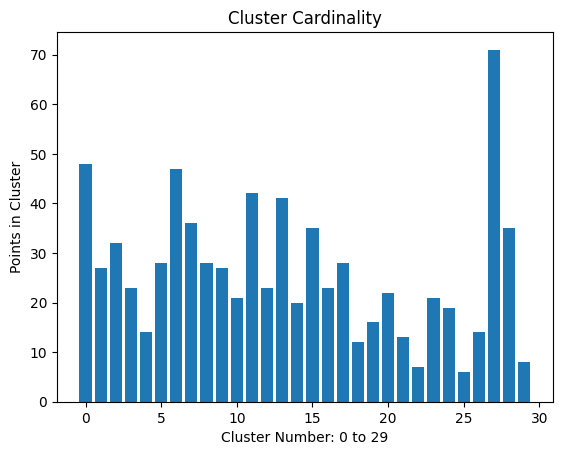

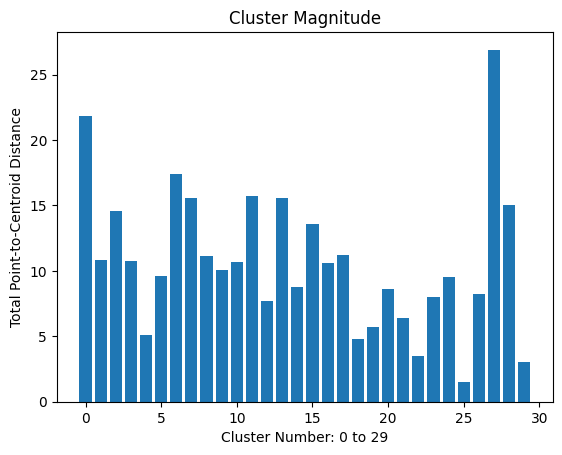

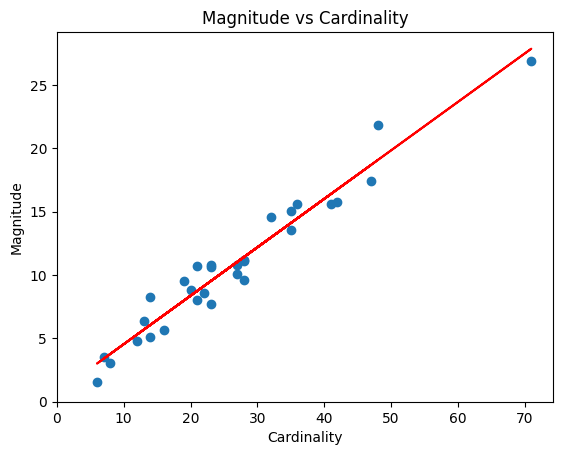

In [34]:
cluster_quality_metrics(choc_data)

<a id='s5_1'></a>
### <font color='darkgreen'>Find Optimum Number of Clusters</font>
You want to find the right number of clusters as you did in the previous
programming exercise. For details, read ["*Step Three: Optimum Number of
Clusters*"](#s3) on the page
[Interpret Results](https://developers.google.com/machine-learning/clustering/interpret).

Run the code below. Does the plot follow the form shown on "*Interpret Results*"? What's the
optimum number of clusters? Experiment with the parameters below if necessary. After considering the questions, expand the next section for a discussion.

k-means converged for 5 clusters after 15 iterations!
k-means converged for 7 clusters after 17 iterations!
k-means converged for 9 clusters after 22 iterations!
k-means converged for 11 clusters after 21 iterations!
k-means converged for 13 clusters after 18 iterations!
k-means converged for 15 clusters after 25 iterations!
k-means converged for 17 clusters after 26 iterations!
k-means converged for 19 clusters after 27 iterations!
k-means converged for 21 clusters after 11 iterations!
k-means converged for 23 clusters after 12 iterations!
k-means converged for 25 clusters after 12 iterations!
k-means converged for 27 clusters after 12 iterations!
k-means converged for 29 clusters after 14 iterations!
k-means converged for 31 clusters after 12 iterations!
k-means converged for 33 clusters after 13 iterations!
k-means converged for 35 clusters after 9 iterations!
k-means converged for 37 clusters after 15 iterations!
k-means converged for 39 clusters after 11 iterations!
k-means conver

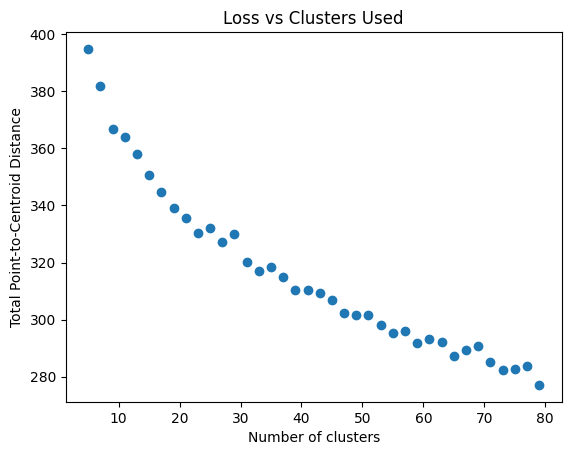

In [36]:
# Plot loss vs number of clusters
def loss_vs_clusters(kmin, kmax, kstep, choc_data):
    kmax += 1  # include kmax-th cluster in range
    k_range = range(kmin, kmax, kstep)
    loss = np.zeros(len(k_range))
    loss_ctr = 0
    for kk in k_range:
        [choc_data, centroids] = kmeans(choc_data, kk, feature_cols, 0)
        loss[loss_ctr] = np.sum(choc_data['pt2centroid'])
        lossCtr += 1
        
    plt.scatter(k_range, loss)
    plt.title('Loss vs Clusters Used')
    plt.xlabel('Number of clusters')
    plt.ylabel('Total Point-to-Centroid Distance')


kmin = 5  # @param
kmax = 80  # @param
kstep = 2  # @param
loss_vs_clusters(kmin, kmax, kstep, choc_data)

<font color='orange'>**Discussion**</font>: The ideal plot of loss vs clusters has a clear inflection point beyond which the decrease in loss flattens out. Here, the plot lacks an obvious inflection point. However, the decrease in loss evens out twice, at approximately `k = 15`
and `k = 35`, suggesting that `k` has optimum values close to 15 and 35. Note that your plot can differ due to the inherent randomness in the k-means algorithm.

<b>You typically see a plot with a clear inflection point plot when the data has naturally clumped
examples</b>. When data doesn't have natural clumps, this plot only hints
as to the optimum value for `k`.

<a id='s5_2'></a>
### <font color='darkgreen'>Discussion</font>
On the page
[Supervised Similarity Measure](https://developers.google.com/machine-learning/clustering/similarity/supervised-similarity),
read the "*Comparison of Manual and Supervised Measures*". Try to connect the description of a manual similarity measure to what your learned from this codelab. Then click below to view the discussion. Lastly, **keep this Colab open** to compare the results with the next Colab that uses a supervised similarity measure.

The Colab demonstrates the following characteristics of a manual similarity metric:

*   **Does not eliminate redundant information in correlated features**. As
    discussed in this [section](#scrollTo=MJtuP9w5jJHq), our manual similarity
    measure did not eliminate redundant information between features.
*   **Provides insight into calculated similarities**. Looking at the clustering
    results, you could see how the maker location and bean origin had a greater
    influence on the clustering result. You saw how the one-hot encoding
    resulted in weighting maker and bean type twice as much as other features.
*   **Suitable for small datasets with few features**. Yes, you could easily
    construct a manual similarity measure for the chocolate dataset since it has
    less than two thousand examples and only nine features.
*   **Not suitable for large datasets with many features**. If the chocolate dataset
    had dozens of features and many thousands of examples, it would be difficult
    to construct a correct similarity measure and then verify the similarity
    measure across the dataset.

## <font color='darkblue'>Appendix: Calculating Point to Centroid Distance for Large Datasets</font>
<b><font size='3ptx'>On every iteration of k-means, your code calculates the distance between every
point and every centroid. When you cluster large numbers of points using many centroids, you must implement
this operation efficiently. Let's see how.</font></b>

Assume you have a vector "P" for a point, and another vector "C" for a centroid.
You need to calculate $||P-C||^2$. Mathematically:

$$||P-C||^2 = |P|^2 + |C|^2 - 2 \cdot P \cdot C$$

The code below generalizes this operation to matrices that represent arbitrary
numbers of points and centroids. Using the code, you can calculate the
point-centroid distances for all combinations of your points and centroids.

In [39]:
%%time
# Calculate distances between "A" point and "B" centroids to return
# axb array where a_i, b_j distance is at (i,j) position
A = np.array([[1, 2, 3],\
              [3, 1, 2],\
              [0, 0, 0]])
A = A / np.max(A)
B = np.array([[4, 5, 6],\
              [6, 6, 6]])
B = B / np.max(B)
numPoints = A.shape[0]
numCentroids = B.shape[0]
pointNorms = np.reshape(nla.norm(A, axis=1)**2.0, [numPoints, 1])
centroidNorms = np.reshape(nla.norm(B, axis=1)**2.0, (1, numCentroids))
print("""Distance matrix of size 'p' by 'c' where Distance between 
point 'p' and centroid 'c' is at (p, c).""")
print(pointNorms + centroidNorms - 2.0 * np.dot(A, np.transpose(B)))

Distance matrix of size 'p' by 'c' where Distance between 
point 'p' and centroid 'c' is at (p, c).
[[0.14 0.56]
 [0.47 0.56]
 [2.14 3.  ]]
CPU times: user 772 µs, sys: 0 ns, total: 772 µs
Wall time: 740 µs


In [43]:
%%time
# Tradition way to calculate distance between every point and every centroid
# will take longer time
A = np.array([[1, 2, 3],\
              [3, 1, 2],\
              [0, 0, 0]])
B = np.array([[4, 5, 6],\
              [6, 6, 6]])

for p in A:
    for c in B:
        print(f'Distance between p={p} and c={c}: {math.dist(p, c):.02f}')

Distance between p=[1 2 3] and c=[4 5 6]: 5.20
Distance between p=[1 2 3] and c=[6 6 6]: 7.07
Distance between p=[3 1 2] and c=[4 5 6]: 5.74
Distance between p=[3 1 2] and c=[6 6 6]: 7.07
Distance between p=[0 0 0] and c=[4 5 6]: 8.77
Distance between p=[0 0 0] and c=[6 6 6]: 10.39
CPU times: user 987 µs, sys: 0 ns, total: 987 µs
Wall time: 985 µs
